In [ ]:
#Ce modèle est utilisé avec le modèle de fichier Model_Transfer_Learning_9classes. Si le modèle Model_Transfer_Learning_9classes
#trouve IG ou Neutrophil on execute le modèle  en bas pour trouver des sous-classes de IG ou Neutrophil. La différence avec le fichier
# Model_Transfer_Learning_9classes_Suite est que ici on utilise Vgg19 aulieu de Vgg16.

In [2]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from matplotlib import cm # To import new color cards
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg19 import VGG19
from sklearn.svm import SVC


In [3]:
filename1 = 'C:/Users/laleh/Documents/Pythons/projet_blood/tests_images/data_1_ALL.pkl'
df1= pickle.load(open(filename1, 'rb'))
filename2 = 'C:/Users/laleh/Documents/Pythons/projet_blood/tests_images/data_1_13_classes.pkl'
df2= pickle.load(open(filename2, 'rb'))

df1=df1[df1.label=='ALL']

df=pd.concat([df2, df1], ignore_index=True)
###  on peut écrire mieux cette partie!!
classes_others=['eosinophil',"platelet","erythroblast","monocyte","basophil","ALL",'lymphocyte']
df['out']=df.label
for i in range(len(df)):
    if df.loc[i,"label"] in classes_others:
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"0")
        
    elif df.loc[i,"label"]=="BNE_BNE":  
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"1")
    elif df.loc[i,"label"]=="BNE_SNE":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"2")
    elif df.loc[i,"label"]=="BNE_NEUTROPHIL":  
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"3")
        
    elif df.loc[i,"label"]=="IG_MY":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"4")
    elif df.loc[i,"label"]=="IG_MMY":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"5")
    elif df.loc[i,"label"]=="IG_PMY":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"6")
    elif df.loc[i,"label"]=="IG_IG":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"7")
        


In [4]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=123)



In [5]:
print(len(list(data_train.out.unique())))
print(len(list(data_test.out.unique())))

8
8


In [6]:


train_data_generator=ImageDataGenerator(
preprocessing_function=preprocess_input,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=1.1,
horizontal_flip=True)

test_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32


train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

Found 13777 validated image filenames belonging to 8 classes.
Found 3445 validated image filenames belonging to 8 classes.


In [7]:
from PIL import Image

def convert_image(X):
    X_img=[]
    for image in X:
        
        
             with Image.open(image) as im:

    
                    img = im.resize((224, 224))
                 
                    
                    a = np.asarray(img)
                    X_img.append(a) 
                    
                    
    return np.array(X_img)

# Load the images train
X_train_img= convert_image(data_train.path)
Y_train = data_train['out']

# Load the images test
X_test_img = convert_image(data_test.path)
Y_test = data_test['out']


# Modèle 

In [8]:

n_class=8



base_model=VGG19(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
    
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(generator=train_generator, 
                                epochs = 1,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
    
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

history = model.fit_generator(generator=train_generator, 
                                epochs = 30,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )


intermediate_layer_model = Model( inputs=model.input, outputs=model.layers[2].output)
X_train_features = intermediate_layer_model.predict(preprocess_input(X_train_img))
X_test_features = intermediate_layer_model.predict(preprocess_input(X_test_img))

svm = SVC(C=111)


grid = svm.fit(X_train_features,  data_train["out"])

80142336/80134624 [==============================] - 2s 0us/step


C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


430/430 [==============================] - 335s 740ms/step - loss: 1.2116 - acc: 0.6308 - val_loss: 0.8647 - val_acc: 0.6703


C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
430/430 [==============================] - 368s 830ms/step - loss: 0.7779 - accuracy: 0.7221 - val_loss: 0.4497 - val_accuracy: 0.8087
Epoch 2/30
430/430 [==============================] - 368s 857ms/step - loss: 0.5923 - accuracy: 0.7718 - val_loss: 0.4255 - val_accuracy: 0.8204
Epoch 3/30
430/430 [==============================] - 367s 854ms/step - loss: 0.5411 - accuracy: 0.7908 - val_loss: 0.2989 - val_accuracy: 0.8756
Epoch 4/30
430/430 [==============================] - 371s 864ms/step - loss: 0.5040 - accuracy: 0.8038 - val_loss: 0.4582 - val_accuracy: 0.8289
Epoch 5/30
430/430 [==============================] - 158s 367ms/step - loss: 0.4836 - accuracy: 0.8109 - val_loss: 0.2600 - val_accuracy: 0.8957
Epoch 6/30
430/430 [==============================] - 159s 369ms/step - loss: 0.4564 - accuracy: 0.8225 - val_loss: 0.2760 - val_accuracy: 0.8881
Epoch 7/30
430/430 [==============================] - 159s 370ms/step - loss: 0.4465 - accuracy: 0.8255 - val_loss: 0.2911 -

In [9]:
classes_names=["Others","BNE_BNE","BNE_SNE","BNE_NEUTROPHIL","IG_MY","IG_MMY","IG_PMY","IG_IG"]
predictions_svm = svm.predict(X_test_features)

from sklearn.metrics import classification_report
print(classification_report(Y_test.values.astype(int),
predictions_svm.astype(int), target_names=classes_names))

                precision    recall  f1-score   support

        Others       0.99      0.99      0.99      2179
       BNE_BNE       0.81      0.81      0.81       313
       BNE_SNE       0.86      0.87      0.86       335
BNE_NEUTROPHIL       0.90      1.00      0.95         9
         IG_MY       0.75      0.72      0.73       262
        IG_MMY       0.73      0.70      0.72       205
        IG_PMY       0.74      0.79      0.76       113
         IG_IG       0.93      0.93      0.93        29

      accuracy                           0.92      3445
     macro avg       0.84      0.85      0.84      3445
  weighted avg       0.92      0.92      0.92      3445



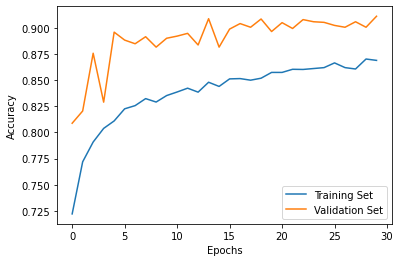

In [10]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(len(training_accuracy)), training_accuracy, label = 'Training Set')
plt.plot(np.arange(len(training_accuracy)), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [11]:
filename = 'svm_Transfer_Learning_B2.pkl'
pickle.dump(svm, open(filename, 'wb'))

#svm= pickle.load(open(filename, 'rb'))

In [12]:
from tensorflow.keras.models import save_model, load_model
save_model(model,"model_Transfer_Learning_B2")
#del model
#model=load_model("model_Transfer_Learning_B")

INFO:tensorflow:Assets written to: model_Transfer_Learning_B2\assets


In [47]:
img_height, img_width=224,224
model1=base_model

########################################################################### Grad-CAM Functions

import matplotlib.cm as cm

def get_img_array(img_path, size = (img_height, img_width)):

  img = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  array = tf.keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  return array

def make_heatmap(img_array, model1, last_conv_layer, class_index):

  grad_model = tf.keras.models.Model([model1.inputs], [last_conv_layer.output, model1.output])
  
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
 
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  for i in range(512):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)
  return heatmap

def gradcam(model1, img_path, class_index = None, alpha = 0.5, plot = True):

  # Détecte la dernière couche de convolution (pas terrible : il faudrait sélectionner sur le type, pas sur le nom) :
  for layer in reversed(model1.layers):                ################
    if 'conv' in layer.name:
      last_conv_layer = model1.get_layer(layer.name)
      break

  # Chargement + mise en forme de l'image :
  img_array = get_img_array(img_path, size = (img_height, img_width))
  """
  # Choix de la classe à représenter :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    model1.layers[-1].activation = None
    # Prédiction + classe la plus probable :
    predict = model1.predict(img_array)
    class_index = np.argmax(predict[0])
 """
  # Calcul de la CAM : resize pour comparaison avec l'image finale
  
  heatmap = make_heatmap(img_array, model1, last_conv_layer, class_index)
  big_heatmap = heatmap
  #big_heatmap = cv2.resize(heatmap, dsize = (img_height, img_width), interpolation = cv2.INTER_CUBIC)

  ## Traitement de la Heatmap
  # 1/ Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()
  # 2/ On passe dans ReLu, pour flinguer les valeurs négatives
  big_heatmap = np.maximum(0, big_heatmap)
  
  ## Superposition de l'image et de la Heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)

  # 3/ Jet colormap
  jet = cm.get_cmap("jet")

  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))
  return big_heatmap, superimposed_img

In [88]:
y_pred = predictions_svm
classes_names=["Others","BNE_BNE","BNE_SNE","BNE_NEUTROPHIL","IG_MY","IG_MMY","IG_PMY","IG_IG"]

# DF avec le résultat et le label de toutes les images du test :
df_results = pd.DataFrame(data = {"real":Y_test.values.astype(int),
                                  "pred":y_pred.astype(int), 
                                  "img_path":data_test["path"],
                                 "label": data_test["label"]})

# Tri des images : mal classé (df_false), bien classé (df_true):
df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)


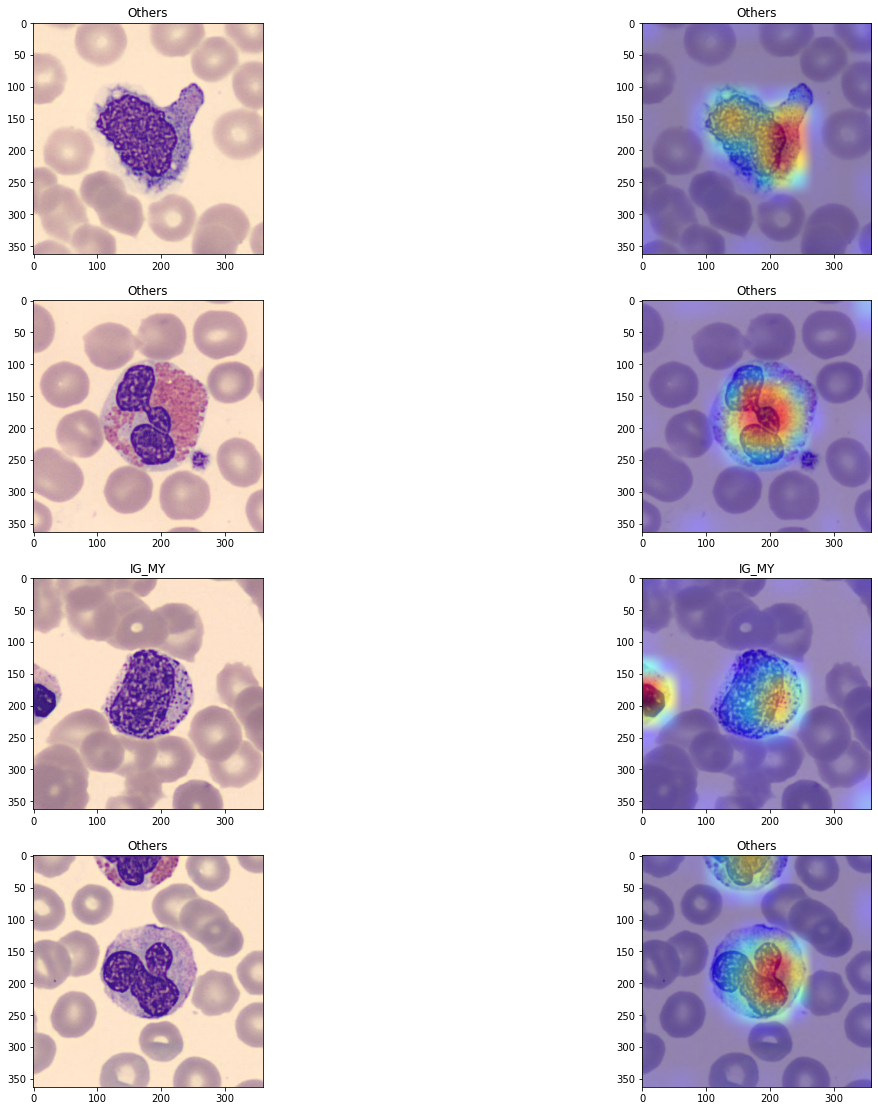

In [85]:
fig = plt.figure(figsize = (20, 40))
i = 0

for j in np.random.randint(0,len(df_true),4):
  
 
  img_path = df_true.loc[j,"img_path"]
 
  big_heatmap, superimposed_img = gradcam(base_model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(8,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(classes_names[df_true.loc[j,"real"]])

  fig.add_subplot(8,2,i+2)
  plt.imshow(superimposed_img)
  plt.title(classes_names[df_true.loc[j,"pred"]])
  i += 2

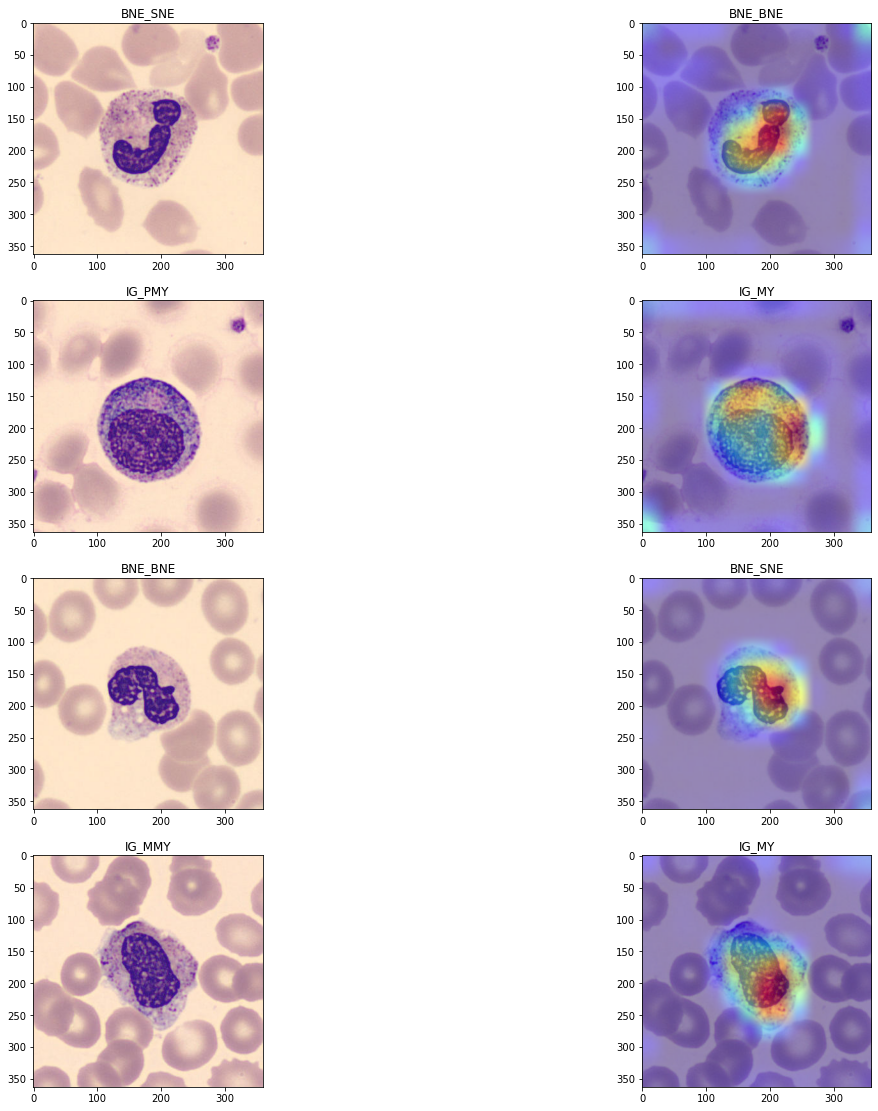

In [87]:
fig = plt.figure(figsize = (20, 40))
i = 0

for j in np.random.randint(0,len(df_false),4):
  
 
  img_path = df_false.loc[j,"img_path"]
 
  big_heatmap, superimposed_img = gradcam(base_model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(8,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(classes_names[df_false.loc[j,"real"]])

  fig.add_subplot(8,2,i+2)
  plt.imshow(superimposed_img)
  plt.title(classes_names[df_false.loc[j,"pred"]])
  i += 2